## MATH3041 Project
## Climate Model

### Importing and Compiling Data

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from ipywidgets import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#######################################################
########## Import/clean temperature data ##############
#######################################################
df_temp = pd.read_csv("Data/nasa_land-ocean_temp_index.txt", delim_whitespace=True)
df_temp['No_Smoothing'] = df_temp['No_Smoothing']+14.15
df_temp = df_temp[['Year','No_Smoothing']]
df_temp.columns = ['YEAR', 'TEMP']


#######################################################
#### Import/clean greenhouse gas concentration data ###
#######################################################
df_gg_1 = pd.read_csv("Data/ice_core_2006.txt", delim_whitespace=True)
df_gg_2 = pd.read_csv("Data/NOAA_MoleFractions_2022.csv")

df_gg_1 = df_gg_1[["YearAD", "CH4spl", "CO2spl","N2Ospl"]]
df_gg_2 = df_gg_2[["YEAR","CO2","CH4","N2O"]]
df_gg_2['YEAR'] = df_gg_2['YEAR']-0.5
df_gg_1.columns = ['YEAR', 'CH4', 'CO2', 'N2O']
#df_gg_1 ranges from 1-2004
#df_gg_2 ranges from 1979-2020
df_gg_2 = df_gg_2[df_gg_2['YEAR']>=2005]


#concat df_gg_2 from 2005 onwards onto the end of df_gg_1
df_gg = pd.concat([df_gg_1, df_gg_2], ignore_index=True)

# TODO: Maybe try averaging the values for the overlapping years since they aren't the same

co2_data = df_gg[['YEAR','CO2']]
ch4_data = df_gg[['YEAR','CH4']]
n2o_data = df_gg[['YEAR','N2O']]

#alternative numpy array approach
#co2_data = df_gg[['YEAR','CO2']].to_numpy()
#print(co2_data[:,0]) #years
#print(co2_data[:,1]) #values

### Define Climate Model Class and Greehouse Gas Classes

In [2]:
#tracks surface temp data, should be changed to track surface ocean and deep ocean temperature 
class climateModel:
    hcap = 51.0 #heat capacity
    climateFeedback = -1.3
    solconst = 1368.0
    albedo = 0.3
    startTime = 1850
    temp_0 = 14
    temp = []
    time = []
    delta_t = 1
    temps = {}
    
    #Can set all parameters, but uses above defaults
    def __init__(self, startTime=startTime, delta_t=delta_t, hcap=hcap, climateFeedback=climateFeedback, solconst=solconst, albedo=albedo, temp_0=temp_0, ggs=[]):
        self.hcap = hcap
        self.solconst = solconst
        self.albedo = albedo
        self.temp_0 = temp_0
        self.climateFeedback = climateFeedback
        self.startTime = startTime
        self.climateInter = self.solconst*(1 - self.albedo)/4 + self.climateFeedback*self.temp_0;
        self.ggs = ggs
        self.temp = [self.temp_0]
        self.time = [self.startTime]
        self.solar_energy = [self.solconst*(1 - self.albedo)/4]
        self.energy_out = [self.climateInter - self.climateFeedback*self.temp_0]
        for g in self.ggs:
            g.forcing(self.startTime)
        self.temps = {"solar": [], "out": [], "co2": [], "ch4": [], "n2o": []}

class greenhouseGas:
    def __init__(self, forcingCoeff, c_0, data=pd.DataFrame([])):
        self.data = data
        self.forcingCoeff = forcingCoeff
        self.c_0 = c_0
    def forcing(self,time):
        pass

class carbonDioxide(greenhouseGas):
    name = "CO2"
    c_0 = 286.8 #278.0 #initial concentration of co2 at 1850 i think?
    forcingCoeff = 5.35
    energy = []
    def __init__(self, forcingCoeff=forcingCoeff, c_0=c_0, data=pd.DataFrame([])):
        super().__init__(forcingCoeff, c_0, data)
        self.energy = []
    
    def forcing(self,time):
        #use real world data
        if not self.data.empty and time in self.data['YEAR'].values:
            c_curr = self.data[self.data['YEAR']==time]['CO2'].item()
        #use cubic estimate if no data provided
        else:
            c_curr = self.c_0*(1 + ((time - 1850)/220)**3) #not sure about the 1850 stuff?
        return self.forcingCoeff*math.log(c_curr/self.c_0)

def gg_interaction(m,n):
    return 0.47 * math.log(1 + 2.01*(10**(-5))*(m*n)**0.75 + 5.31*(10**(-15))*m*(m*n)**1.52)
    
class methane(greenhouseGas):
    name = "CH4"
    c_0 = 783.8 #722.0 #initial concentration of ch4 at 1850 i think?
    cn_0 = 270.4 #270.0 #initial concentration of n2o at 1850 i think?
    forcingCoeff = 0.036
    
    def __init__(self, forcingCoeff=forcingCoeff, c_0=c_0, cn_0=cn_0, data=pd.DataFrame([])):
        super().__init__(forcingCoeff, c_0, data)
        self.energy = []
        self.cn_0 = cn_0
    
    def forcing(self,time):
        if not self.data.empty and time in self.data['YEAR'].values:
            c_curr = self.data[self.data['YEAR']==time]['CH4'].item()
        #use initial concentration if no data provided
        else:
            c_curr = self.c_0 
        return self.forcingCoeff*(math.sqrt(c_curr) - math.sqrt(self.c_0)) - (gg_interaction(c_curr,self.cn_0) - gg_interaction(self.c_0,self.cn_0))

class nitrousOxide(greenhouseGas):
    name = "N2O"
    c_0 = 270.4 #270.0 #initial concentration of n2o at 1850 i think?
    cm_0 = 783.8 #722.0 #initial concentration of ch4 at 1850 i think?
    forcingCoeff = 0.12
    
    def __init__(self, forcingCoeff=forcingCoeff, c_0=c_0, cm_0=cm_0, data=[]):
        super().__init__(forcingCoeff, c_0, data)
        self.cm_0 = cm_0
        self.energy = []        
    
    def forcing(self,time):
        if not self.data.empty and time in self.data['YEAR'].values:
            c_curr = self.data[self.data['YEAR']==time]['N2O'].item()
        #use initial concentration if no data provided
        else:
            c_curr = self.c_0 
        return self.forcingCoeff*(math.sqrt(c_curr) - math.sqrt(self.c_0)) - (gg_interaction(self.cm_0,c_curr) - gg_interaction(self.cm_0,self.c_0))

print("Classes compiled")


Classes compiled


### Define Functions to Run the Climate Simulation

In [3]:
def solar_energy_in(s, a):
    return s*(1 - a)/4

def energy_leaving_surface(T, A, B):
    return A - B * T

def volcanic_aerosol_reflection():
    return 0

def human_aerosol_reflection():
    return 0
    #return k_h * mass of material emitted per second

def greenhouse_effect(ggs,time):
    ef = 0.0
    for g in ggs:
        f = g.forcing(time)
        ef = ef + f
        g.energy.append(f)
    return ef
            

def tendency(model):
    model.solar_energy.append(solar_energy_in(model.solconst, model.albedo))
    return (1/model.hcap) * (solar_energy_in(model.solconst, model.albedo) \
            - volcanic_aerosol_reflection() \
            - human_aerosol_reflection() \
            - energy_leaving_surface(model.temp[-1], model.climateInter, model.climateFeedback) \
            + greenhouse_effect(model.ggs, model.time[-1]))
    
def timeStep(model):
    model.temp.append(model.temp[-1] + model.delta_t*tendency(model))
    #temp for each forcing factor:
    model.temps['solar'].append(model.delta_t*(1/model.hcap)*solar_energy_in(model.solconst, model.albedo))
    model.temps['out'].append(-model.delta_t*(1/model.hcap)*energy_leaving_surface(model.temp[-1], model.climateInter, model.climateFeedback))
    model.temps['co2'].append(model.delta_t*(1/model.hcap)*model.ggs[0].forcing(model.time[-1]))
    model.temps['ch4'].append(model.delta_t*(1/model.hcap)*model.ggs[1].forcing(model.time[-1]))
    model.temps['n2o'].append(model.delta_t*(1/model.hcap)*model.ggs[2].forcing(model.time[-1]))
    model.time.append(model.time[-1] + model.delta_t)

def runSimulation(model, end_year):
    while model.time[-1] < end_year:
        timeStep(model)
    print("Finished Simulation")
    print("Plotting Results")

### Run the Simulation and Plot Results

Finished Simulation
Plotting Results


<IPython.core.display.Javascript object>


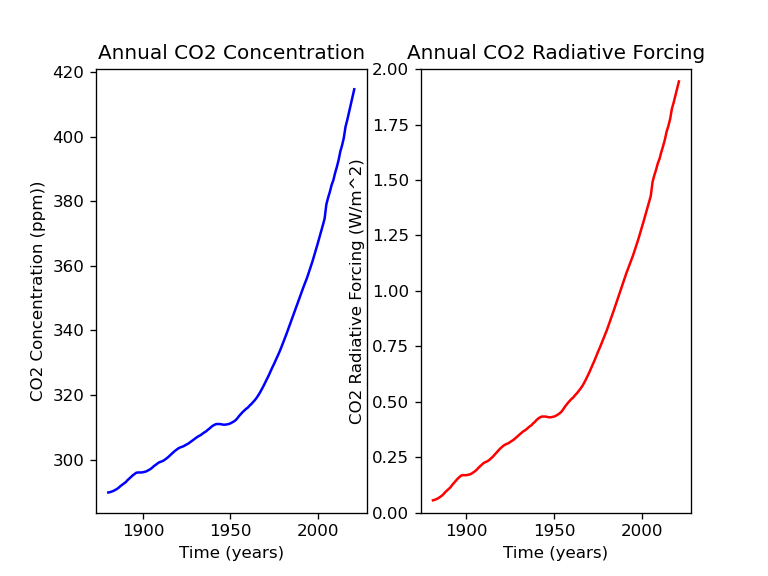

<IPython.core.display.Javascript object>


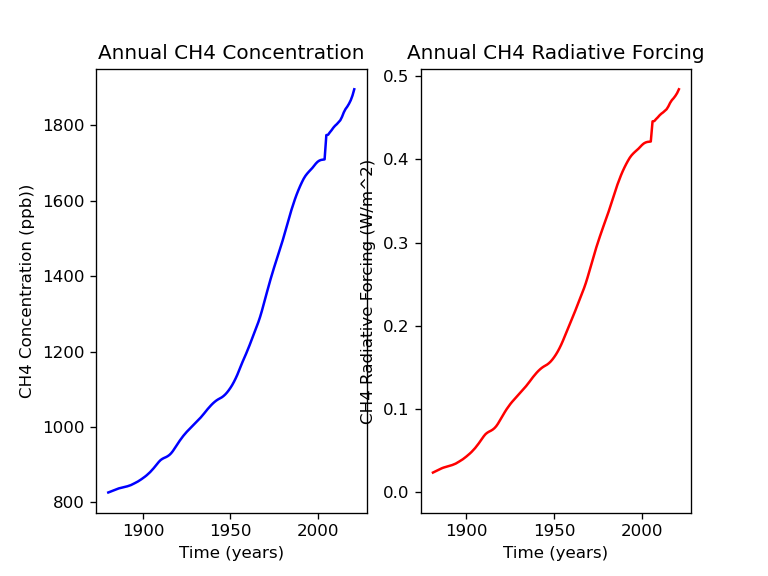

<IPython.core.display.Javascript object>


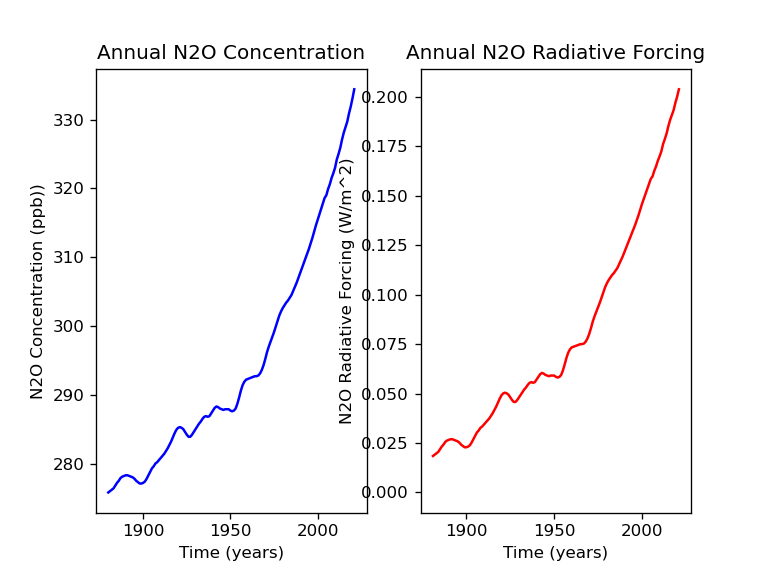

<IPython.core.display.Javascript object>


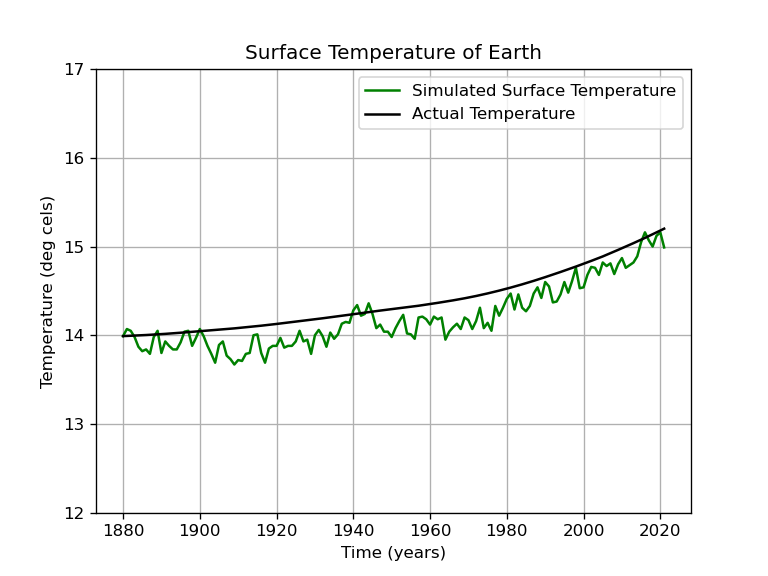

<IPython.core.display.Javascript object>


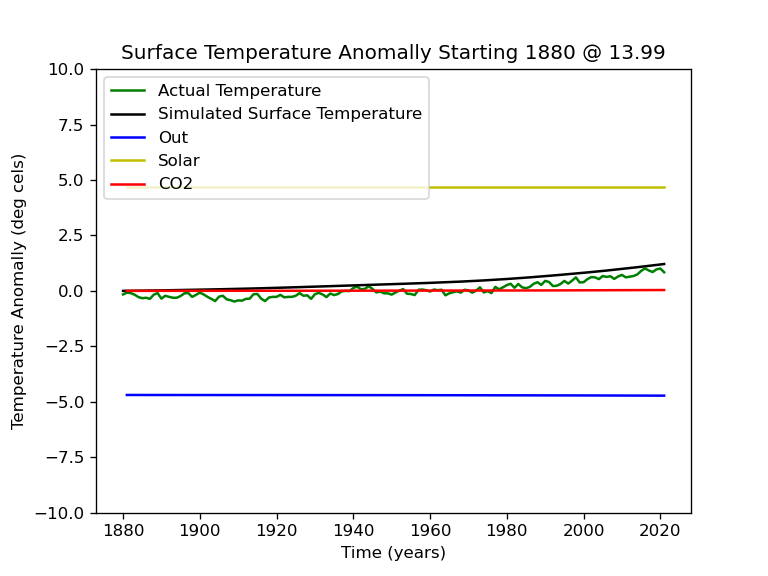

interactive(children=(FloatSlider(value=-1.3, description='Climate_feedback', max=4.0, min=-4.0), IntSlider(va…

<function __main__.update_surf(Climate_feedback=-1.3, Heat_Capacity=51.0, CO2_Forcing=5.35, CH4_Forcing=0.036, N2O_Forcing=0.12, alb=0.3)>

In [9]:
startYear = 1880
endYear = 2021
co2_0 = co2_data[co2_data['YEAR']==startYear]['CO2'].item()
ch4_0 = ch4_data[ch4_data['YEAR']==startYear]['CH4'].item()
n2o_0 = n2o_data[n2o_data['YEAR']==startYear]['N2O'].item()
t_0 = df_temp[df_temp['YEAR']==startYear]['TEMP'].item()

co2 = carbonDioxide(data=co2_data, c_0 = co2_0)
ch4 = methane(data=ch4_data, c_0 = ch4_0, cn_0 = n2o_0)
n2o = nitrousOxide(data=n2o_data, c_0 = n2o_0, cm_0 = ch4_0)

mod = climateModel(ggs=[co2,ch4,n2o], startTime=startYear, temp_0 = t_0)
runSimulation(mod, endYear)

#Q1: Rate of change of surface temp due to changes in radiative forcing

#Plot CO2 information
fig_co2, (axc_co2, axf_co2) = plt.subplots(1, 2)
linec_co2, = axc_co2.plot(co2_data[co2_data['YEAR']>=startYear]['YEAR'].tolist(), co2_data[co2_data['YEAR']>=startYear]['CO2'].tolist(), color='b')
axc_co2.set_title("Annual CO2 Concentration")
axc_co2.set_xlabel("Time (years)")
axc_co2.set_ylabel("CO2 Concentration (ppm))")
linef_co2, = axf_co2.plot(mod.time[1:], co2.energy, color='r')
axf_co2.set_title("Annual CO2 Radiative Forcing")
axf_co2.set_xlabel("Time (years)")
axf_co2.set_ylabel("CO2 Radiative Forcing (W/m^2)")

#Plot CH4 information
fig_ch4, (axc_ch4, axf_ch4) = plt.subplots(1, 2)
linec_ch4, = axc_ch4.plot(ch4_data[ch4_data['YEAR']>=startYear]['YEAR'].tolist(), ch4_data[ch4_data['YEAR']>=startYear]['CH4'].tolist(), color='b')
axc_ch4.set_title("Annual CH4 Concentration")
axc_ch4.set_xlabel("Time (years)")
axc_ch4.set_ylabel("CH4 Concentration (ppb))")
linef_ch4, = axf_ch4.plot(mod.time[1:], ch4.energy, color='r')
axf_ch4.set_title("Annual CH4 Radiative Forcing")
axf_ch4.set_xlabel("Time (years)")
axf_ch4.set_ylabel("CH4 Radiative Forcing (W/m^2)")

#Plot N2O information
fig_n2o, (axc_n2o, axf_n2o) = plt.subplots(1, 2)
linec_n2o, = axc_n2o.plot(n2o_data[n2o_data['YEAR']>=startYear]['YEAR'].tolist(), n2o_data[n2o_data['YEAR']>=startYear]['N2O'].tolist(), color='b')
axc_n2o.set_title("Annual N2O Concentration")
axc_n2o.set_xlabel("Time (years)")
axc_n2o.set_ylabel("N2O Concentration (ppb))")
linef_n2o, = axf_n2o.plot(mod.time[1:], n2o.energy, color='r')
axf_n2o.set_title("Annual N2O Radiative Forcing")
axf_n2o.set_xlabel("Time (years)")
axf_n2o.set_ylabel("N2O Radiative Forcing (W/m^2)")

# Interactive plot of temperature
figt = plt.figure()
axt = figt.add_subplot(1, 1, 1)
line_realt, = axt.plot(df_temp['YEAR'].tolist(), df_temp['TEMP'].tolist(), color='g')
line_simt, = axt.plot(mod.time, mod.temp, color='k')
axt.set_title("Surface Temperature of Earth")
axt.set_xlabel("Time (years)")
axt.set_ylabel("Temperature (deg cels)")
axt.legend(["Actual Temperature", "Simulated Surface Temperature"])
axt.grid()
#plt.rcParams['figure.figsize'] = [15, 100]
# Interactive plot of temperature anomally
figa = plt.figure()
axa = figa.add_subplot(1, 1, 1)
line_reala, = axa.plot(df_temp['YEAR'].tolist(), (df_temp['TEMP']-14.15).tolist(), color='g')
line_sima, = axa.plot(mod.time, [t - mod.temp_0 for t in mod.temp], color='k')
line_outa, = axa.plot(mod.time[1:], mod.temps['out'], color='b')
line_sola, = axa.plot(mod.time[1:], mod.temps['solar'], color='y')
line_co2a, = axa.plot(mod.time[1:], mod.temps['co2'], color='r')
axa.set_title("Surface Temperature Anomally Starting {} @ {}".format(startYear, t_0))
axa.set_xlabel("Time (years)")
axa.set_ylabel("Temperature Anomally (deg cels)")
axa.legend(["Actual Temperature", "Simulated Surface Temperature","Out", "Solar", "CO2"])
#axa.grid()


def update_surf(Climate_feedback=-1.3, Heat_Capacity=51.0, CO2_Forcing=5.35, CH4_Forcing=0.036, N2O_Forcing=0.12, alb=0.3):
    co2u = carbonDioxide(data=co2_data, forcingCoeff=CO2_Forcing)
    ch4u = methane(data=ch4_data, forcingCoeff=CH4_Forcing)
    n2ou = nitrousOxide(data=n2o_data, forcingCoeff=N2O_Forcing)
    modu = climateModel(ggs=[co2u,ch4u,n2ou], 
                        startTime=startYear, temp_0 = df_temp[df_temp['YEAR']==startYear]['TEMP'].item(),
                        climateFeedback=Climate_feedback, hcap=Heat_Capacity, albedo=alb)
    runSimulation(modu, endYear)
    
    
    global line_simt, line_sima, line_outa, line_sola, line_co2a, linef_co2, linef_ch4, linef_n2o
    axt.lines.remove(axt.lines[1])
    axf_co2.lines.remove(axf_co2.lines[0])
    axf_ch4.lines.remove(axf_ch4.lines[0])
    axf_n2o.lines.remove(axf_n2o.lines[0])
    [axa.lines.remove(x) for x in axa.lines[1:]]
    
    #line_simt.remove()
    #line_sima.remove()
    #line_outa.remove()
    #line_co2a.remove()
    #linef_co2.remove()
    #linef_ch4.remove()
    #linef_n2o.remove()
    
    #axt.lines.remove(axt.lines[1])
    #axf_co2.lines.remove(axf_co2.lines[0])
    #axf_ch4.lines.remove(linef_ch4)
    #axf_n2o.lines.remove(linef_n2o)
    #[axa.lines.remove(l) for l in [line_sima, line_outa, line_sola, line_co2a]]
    
    line_simt = axt.plot(modu.time, modu.temp, color='k')
    linef_co2, = axf_co2.plot(modu.time[1:], co2u.energy,color='r')
    linef_ch4, = axf_ch4.plot(modu.time[1:], ch4u.energy, color='r')
    linef_n2o, = axf_n2o.plot(modu.time[1:], n2ou.energy, color='r')
    line_sima = axa.plot(modu.time, [t - modu.temp_0 for t in modu.temp], color='k')
    line_outa, = axa.plot(modu.time[1:], modu.temps['out'], color='b')
    line_sola, = axa.plot(modu.time[1:], modu.temps['solar'], color='y')
    line_co2a, = axa.plot(modu.time[1:], modu.temps['co2'], color='r')
    
    axt.set_ylim(12,17)
    axa.set_ylim(-10,10)
    axf_co2.set_ylim(0,2)
    plt.show()

interact(update_surf, Climate_feedback = (-4.0,4.0,0.1), Heat_Capacity = (1,100,1), CO2_Forcing = (0,20,0.1), CH4_Forcing=(0,5,0.001), N2O_Forcing=(0,5,0.01), alb=(0,1,0.1))